### Imports and Loading of Dataset

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import requests

from xgboost import XGBRegressor

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error,root_mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [4]:
# Load the dataset
df = pd.read_csv('../../final_dataset.csv')


### Data Exploration & Feature Selection

In [5]:
# Display all columns of the dataframe
pd.set_option('display.max_columns', None)
df.head()

,datetime,homeid,Gas (kWh),Electricity (kWh),Total (kWh),temp_mean,temp_min,temp_max,location_id,location_name,residents,hometype,occupied_days,occupied_nights,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,mean_t,min_t,max_t,average_age_numeric,workstatus,total_participants
0,2018-02-21,299,21.603,3.725250,25.328250,5.169474,2.9,6.9,1,Edinburgh,1,house_or_bungalow,7,7,0,14,9,3,695,9,6,37.608684,30.0,48.2,16.689213,15.2,17.6,67.0,1.0,1
1,2018-02-22,299,23.288,3.692155,26.980155,3.996875,1.7,7.3,1,Edinburgh,1,house_or_bungalow,7,7,0,14,9,3,695,9,6,34.672411,28.4,40.6,16.795971,15.3,17.6,67.0,1.0,1
2,2018-02-23,299,30.005,3.922362,33.927362,2.465625,-0.2,5.8,1,Edinburgh,1,house_or_bungalow,7,7,0,14,9,3,695,9,6,33.099335,28.1,38.7,16.404040,14.2,17.7,67.0,1.0,1
3,2018-02-24,299,31.113,4.658932,35.771932,2.642708,-0.2,6.4,1,Edinburgh,1,house_or_bungalow,7,7,0,14,9,3,695,9,6,33.380109,27.5,39.8,15.941472,13.6,18.1,67.0,1.0,1
4,2018-02-27,299,47.230,3.894231,51.124231,0.740625,-2.1,2.9,1,Edinburgh,1,house_or_bungalow,7,7,0,14,9,3,695,9,6,28.455956,22.7,36.0,16.123227,14.8,17.4,67.0,1.0,1


In [6]:
# List all columns
df.columns

Index(['datetime', 'homeid', 'Gas (kWh)', 'Electricity (kWh)', 'Total (kWh)',
       'temp_mean', 'temp_min', 'temp_max', 'location_id', 'location_name',
       'residents', 'hometype', 'occupied_days', 'occupied_nights',
       'entry_floor', 'income_band_num', 'electric_appliance', 'gas_appliance',
       'total_area', 'room_count', 'windowsopen', 'mean_h', 'min_h', 'max_h',
       'mean_t', 'min_t', 'max_t', 'average_age_numeric', 'workstatus',
       'total_participants'],
      dtype='object')

In [7]:

# Define the needed columns
selected_features = [
                    # 'datetime',
                    # 'homeid',
                    'Gas (kWh)',
                    'Electricity (kWh)',
                    'Total (kWh)',
                    'temp_mean',
                    'temp_min',
                    'temp_max',
                    # 'location_id',
                    # 'location_name',
                    'residents',
                    'hometype',
                    'occupied_days',
                    'occupied_nights',
                    'entry_floor',
                    'income_band_num',
                    'electric_appliance',
                    'gas_appliance',
                    'total_area',
                    'room_count',
                    'windowsopen',
                    'mean_h',
                    'min_h',
                    'max_h',
                    'mean_t',
                    'min_t',
                    'max_t',
                    'average_age_numeric',
                    'workstatus',
                    'total_participants']

df_selected = df[selected_features]

In [8]:
# Show the number of missing values in each column
df_selected.describe()

,Gas (kWh),Electricity (kWh),Total (kWh),temp_mean,temp_min,temp_max,residents,occupied_days,occupied_nights,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,mean_t,min_t,max_t,average_age_numeric,workstatus,total_participants
count,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,45115.000000,44821.000000,44821.000000,44821.000000,44521.000000,44521.000000,44521.000000,45115.000000,45115.000000,45115.000000
mean,41.511825,8.563868,50.075693,8.846785,5.772832,12.269387,2.424648,4.105464,6.808445,0.694359,6.117300,7.831896,3.623473,859.697107,8.602749,5.805298,51.728847,47.396511,57.811651,18.282872,17.009885,19.668076,38.899902,0.148543,2.436529
std,60.411530,5.141953,62.108576,5.197923,4.671558,6.279190,1.071548,2.119832,0.761730,1.190843,3.960933,2.038025,1.099365,291.463108,2.239864,1.890926,9.766638,10.251616,10.993503,3.383900,3.663867,3.641130,14.628394,0.294362,1.053739
min,-388.834000,0.192421,-382.710290,-3.907292,-7.500000,-2.500000,0.000000,0.000000,0.000000,-1.000000,0.000000,3.000000,1.000000,325.000000,4.000000,2.000000,13.462526,4.600000,16.600000,0.000000,0.000000,0.000000,15.750000,0.000000,1.000000
25%,6.952000,4.964122,14.481936,4.502083,2.000000,7.100000,2.000000,2.000000,7.000000,0.000000,3.000000,7.000000,3.000000,660.000000,7.000000,4.000000,44.727383,40.200000,50.200000,17.079454,15.700000,18.400000,27.000000,0.000000,2.000000
50%,24.686000,7.627402,32.572547,8.576344,5.500000,11.700000,2.000000,4.000000,7.000000,0.000000,5.000000,8.000000,4.000000,810.000000,8.000000,5.000000,51.738008,47.300000,57.500000,18.892382,17.700000,20.100000,33.666667,0.000000,2.000000
75%,57.542000,10.999262,67.383661,13.222917,9.900000,17.100000,3.000000,6.000000,7.000000,1.000000,9.000000,9.000000,4.000000,1025.000000,10.000000,7.000000,58.651259,54.600000,65.200000,20.339671,19.300000,21.700000,49.500000,0.000000,3.000000
max,3706.452000,102.616242,3715.519872,23.566667,20.700000,32.300000,5.000000,7.000000,7.000000,6.000000,15.000000,13.000000,6.000000,1865.000000,15.000000,11.000000,85.155286,84.200000,102.400000,29.548651,27.800000,49.500000,85.000000,1.000000,5.000000


#### Outside Temperature (temp_mean, temp_min, temp_max) ✅

In [9]:
# Check for missing values
df_selected['temp_max'].isnull().sum(), df_selected['temp_min'].isnull().sum(), df_selected['temp_mean'].isnull().sum()

(0, 0, 0)

<Axes: xlabel='temp_mean', ylabel='Electricity (kWh)'>

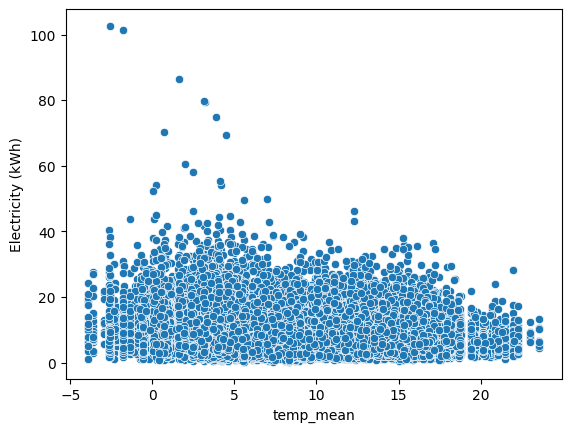

In [10]:
# Plot Electricity consumption against temp_mean
sns.scatterplot(data=df_selected, x='temp_mean', y='Electricity (kWh)')

No null values so can move on

#### Residents & Total Participants ✅❌

<Axes: xlabel='Electricity (kWh)', ylabel='residents'>

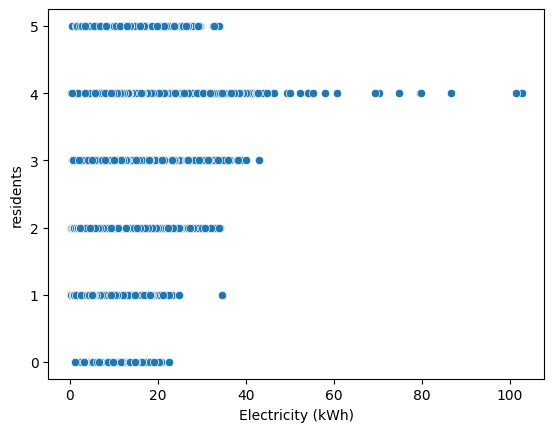

In [11]:
# Plot Electricity (kWh) with hue as residents
sns.scatterplot(data=df_selected, x='Electricity (kWh)', y='residents')

In [12]:
# Find where total participants is above 0 and residents is 0
df_selected[(df_selected['total_participants'] > 0) & (df_selected['residents'] == 0)]

,Gas (kWh),Electricity (kWh),Total (kWh),temp_mean,temp_min,temp_max,residents,hometype,occupied_days,occupied_nights,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,mean_t,min_t,max_t,average_age_numeric,workstatus,total_participants
3309,76.554,13.909414,90.463414,3.358333,1.3,5.3,0,house_or_bungalow,2,7,0,2,10,4,995,10,5,38.290318,36.2,42.1,19.441239,18.5,20.5,42.0,0.0,1
3310,93.452,11.476263,104.928263,1.177083,-1.2,3.9,0,house_or_bungalow,2,7,0,2,10,4,995,10,5,36.111181,31.6,45.5,20.251909,19.2,21.5,42.0,0.0,1
3311,76.336,10.819677,87.155677,4.672917,-0.3,9.4,0,house_or_bungalow,2,7,0,2,10,4,995,10,5,36.005038,32.1,42.3,19.755554,18.9,20.4,42.0,0.0,1
3312,73.218,10.317135,83.535135,4.881250,1.6,6.9,0,house_or_bungalow,2,7,0,2,10,4,995,10,5,38.069117,36.0,42.9,19.509920,19.0,20.0,42.0,0.0,1
3313,49.811,6.014498,55.825498,9.984375,6.7,11.8,0,house_or_bungalow,2,7,0,2,10,4,995,10,5,42.859505,38.3,48.8,19.740438,18.2,20.8,42.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22271,55.428,15.020007,70.448007,0.479167,-1.8,2.3,0,flat,5,7,0,12,8,3,745,6,4,39.667353,36.7,43.6,16.148381,14.7,18.8,32.0,0.0,1
22272,57.775,13.569699,71.344699,0.223958,-2.0,1.9,0,flat,5,7,0,12,8,3,745,6,4,40.158658,37.0,43.1,15.712588,14.6,18.2,32.0,0.0,1
22273,92.486,18.218409,110.704409,2.820833,0.8,6.4,0,flat,5,7,0,12,8,3,745,6,4,39.822307,36.4,45.2,15.990136,14.5,18.4,32.0,0.0,1
22274,84.517,19.003741,103.520741,4.996875,1.1,11.4,0,flat,5,7,0,12,8,3,745,6,4,43.388627,35.9,48.0,16.658348,15.0,19.8,32.0,0.0,1


In [13]:
# We can change residents = 0 to 1
df_s1 = df_selected.copy()
df_s1['residents'] = df_selected['residents'].apply(lambda x: 1 if x == 0 else x).copy()
df_s1['residents'].value_counts()

residents
2    18136
3     9876
1     8445
4     7631
5     1027
Name: count, dtype: int64

In [14]:
# Check difference between residents and total participants
(df_s1['residents'] - df_s1['total_participants']).describe()

count    45115.000000
mean         0.001773
std          0.307862
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
dtype: float64

In [15]:
# Show rows where residents - total_participants is below 0
df[df['residents'] - df['total_participants'] < 0][['homeid']].value_counts()

homeid
66        497
59        355
128       327
114       311
228       196
271       185
167       159
219       145
171        90
Name: count, dtype: int64

#### Hometype ✅

In [16]:
df_selected['hometype'].value_counts()

hometype
flat                 25364
house_or_bungalow    19751
Name: count, dtype: int64

no null values, so can keep the same

#### Occupied Days and Nights ❌

In [17]:
df_selected['occupied_days'].value_counts()

occupied_days
2    11677
7    11187
4     7310
3     5078
6     3636
1     2905
5     2872
0      450
Name: count, dtype: int64

In [18]:
df_selected['occupied_nights'].value_counts()

occupied_nights
7    41750
5     1463
4      919
6      507
2      221
3      146
0      109
Name: count, dtype: int64

#### Entry Floor ✅

In [19]:
df_selected['entry_floor'].value_counts()

entry_floor
 0    29571
 2     5969
 1     4547
 3     3363
 5      612
-1      574
 4      304
 6      175
Name: count, dtype: int64

no null values, can ignore

#### Income Bands ❌

In [20]:
df_selected['income_band_num'].value_counts()

income_band_num
5     6478
3     5419
2     4358
11    3667
1     3496
6     3152
4     3111
7     2889
8     2790
9     2714
15    1525
12    1398
0     1210
14    1118
13    1086
10     704
Name: count, dtype: int64

#### Appliances (electric_appliance, gas_appliance) ✅

In [21]:
df_selected['electric_appliance'].value_counts()

electric_appliance
8     10054
7      7583
9      6814
10     6017
6      5261
5      3013
11     1895
4      1857
12     1140
3       951
13      530
Name: count, dtype: int64

In [22]:
df_selected['gas_appliance'].value_counts()

gas_appliance
4    16102
3    10574
5     9578
2     7097
1     1065
6      699
Name: count, dtype: int64

#### Total Area ✅

<Axes: ylabel='total_area'>

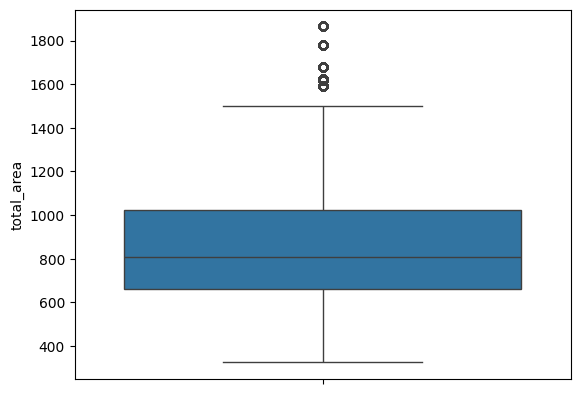

In [23]:
# Boxplot of total_area to check for outliers
sns.boxplot(data=df_selected, y='total_area')


In [24]:
df_selected['total_area'].describe()

count    45115.000000
mean       859.697107
std        291.463108
min        325.000000
25%        660.000000
50%        810.000000
75%       1025.000000
max       1865.000000
Name: total_area, dtype: float64

#### Room Count ✅

In [25]:
df_selected['room_count'].value_counts()

room_count
7     8098
9     7757
8     6022
6     5978
10    4957
11    4413
12    3227
5     2583
14     918
13     781
15     299
4       82
Name: count, dtype: int64

0         9
1         9
2         9
3         9
4         9
         ..
45110    11
45111    11
45112    11
45113    11
45114    11
Name: room_count, Length: 45115, dtype: int64

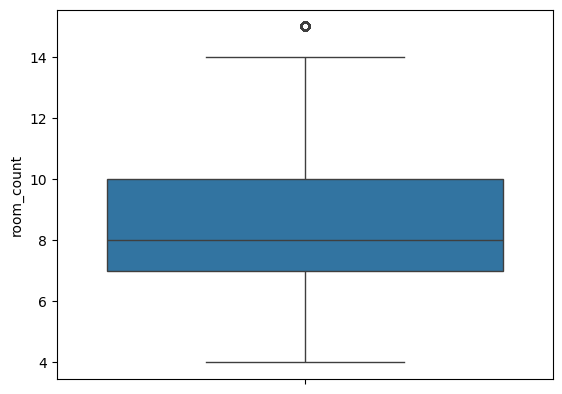

In [26]:
# Box plot to check for outliers
sns.boxplot(data=df_selected, y='room_count')
df_selected['room_count']

Only one outlier so we can let it stay

#### Windows Open ✅

In [27]:
df_selected['windowsopen'].value_counts()

windowsopen
4     10327
5     10324
6      6712
7      5285
8      4538
9      3781
3      2219
10      972
2       614
11      343
Name: count, dtype: int64

<Axes: ylabel='windowsopen'>

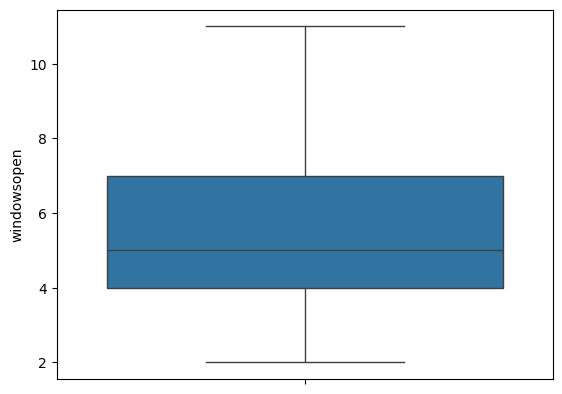

In [28]:
# Box plot to check for outliers
sns.boxplot(data=df_selected, y='windowsopen')

No Outliers so we can keep it as is

#### Internal Humidity (mean_h, min_h, max_h) ✅

<Axes: >

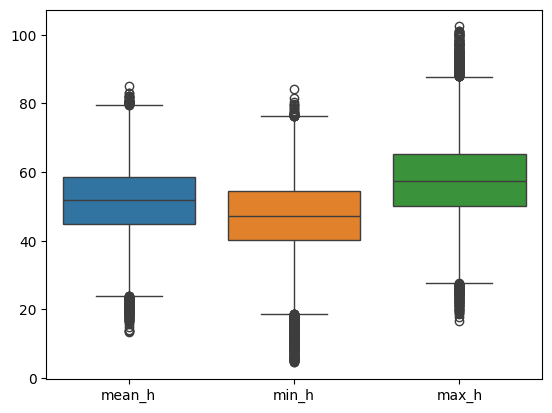

In [29]:
# Box plot to check for outliers for all 3 humidity columns
sns.boxplot(data=df_selected[['mean_h', 'min_h', 'max_h']])

In [30]:
# Check distribution of the 3 humidity columns
df_selected[['mean_h', 'min_h', 'max_h']].describe()

,mean_h,min_h,max_h
count,44821.000000,44821.000000,44821.000000
mean,51.728847,47.396511,57.811651
std,9.766638,10.251616,10.993503
min,13.462526,4.600000,16.600000
25%,44.727383,40.200000,50.200000
50%,51.738008,47.300000,57.500000
75%,58.651259,54.600000,65.200000
max,85.155286,84.200000,102.400000


<Axes: ylabel='Count'>

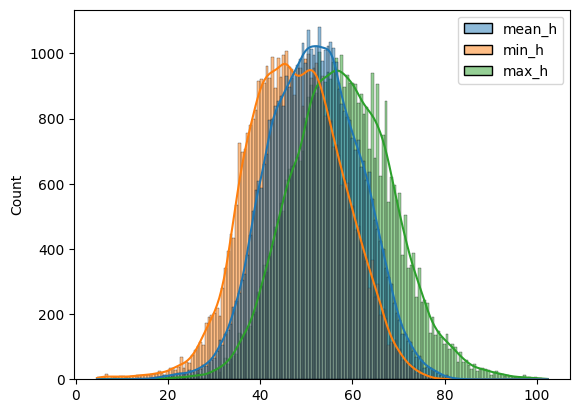

In [31]:
sns.histplot(data=df_selected[['mean_h', 'min_h', 'max_h']], kde=True)

As there are many outliers, robust scaling can be used

#### Internal Temperatures (mean_t, min_t, max_t) ❌

<Axes: >

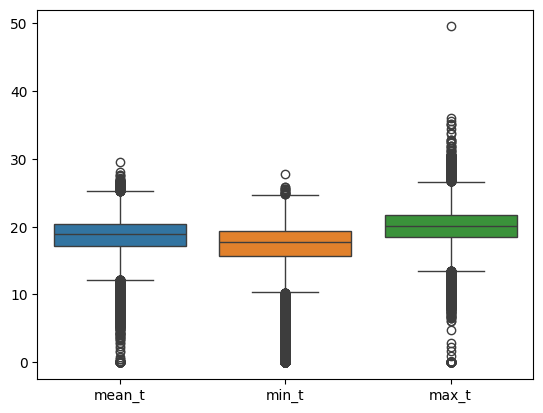

In [32]:
# Box plot to check for outliers for all 3 temperature columns
sns.boxplot(data=df_selected[['mean_t', 'min_t', 'max_t']])

<Axes: ylabel='Count'>

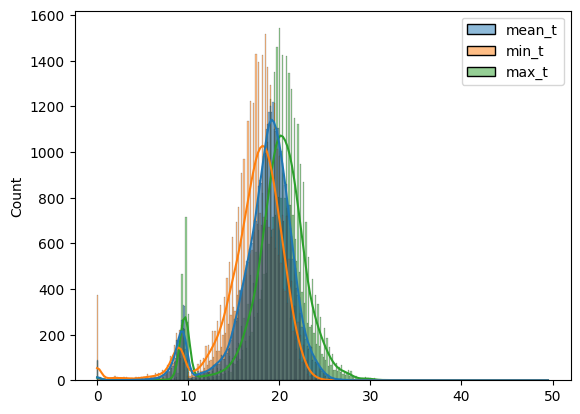

In [33]:
sns.histplot(data=df_selected[['mean_t', 'min_t', 'max_t']], kde=True)

Seems like a lot of issues with internal temperature, maybe better to drop these features

#### Average Resident Age (average_age_numeric) ✅

<Axes: ylabel='average_age_numeric'>

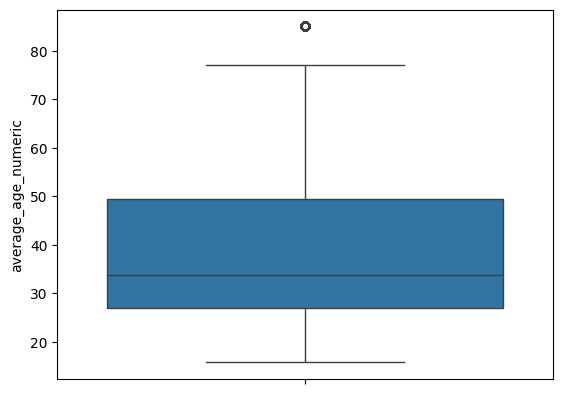

In [34]:
# Boxplot average age to check for outliers
sns.boxplot(data=df_selected, y='average_age_numeric')

Only one outlier, so we can keep that in the dataset

#### Workstatus ✅

In [35]:
df_selected['workstatus'].value_counts()

workstatus
0.000000    33970
0.500000     4293
1.000000     3454
0.333333     2334
0.250000      523
0.200000      262
0.400000      173
0.666667      106
Name: count, dtype: int64

No missing data, so ignore

### Final Features

In [36]:
# Define the needed columns
final_features = [
                    # 'datetime',
                    # 'homeid',
                    'Gas (kWh)',
                    'Electricity (kWh)',
                    'Total (kWh)',
                    'temp_mean',
                    'temp_min',
                    'temp_max',
                    # 'location_id',
                    # 'location_name',
                    'residents',
                    'hometype',
                    # 'occupied_days',
                    # 'occupied_nights',
                    'entry_floor',
                    'income_band_num',
                    'electric_appliance',
                    'gas_appliance',
                    'total_area',
                    'room_count',
                    'windowsopen',
                    'mean_h',
                    'min_h',
                    'max_h',
                    # 'mean_t',
                    # 'min_t',
                    # 'max_t',
                    'average_age_numeric',
                    'workstatus',
                    'total_participants']

df_final = df_s1[final_features]

### Data Preprocessing

In [37]:
df_final

,Gas (kWh),Electricity (kWh),Total (kWh),temp_mean,temp_min,temp_max,residents,hometype,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,average_age_numeric,workstatus,total_participants
0,21.603,3.725250,25.328250,5.169474,2.9,6.9,1,house_or_bungalow,0,14,9,3,695,9,6,37.608684,30.0,48.2,67.0,1.0,1
1,23.288,3.692155,26.980155,3.996875,1.7,7.3,1,house_or_bungalow,0,14,9,3,695,9,6,34.672411,28.4,40.6,67.0,1.0,1
2,30.005,3.922362,33.927362,2.465625,-0.2,5.8,1,house_or_bungalow,0,14,9,3,695,9,6,33.099335,28.1,38.7,67.0,1.0,1
3,31.113,4.658932,35.771932,2.642708,-0.2,6.4,1,house_or_bungalow,0,14,9,3,695,9,6,33.380109,27.5,39.8,67.0,1.0,1
4,47.230,3.894231,51.124231,0.740625,-2.1,2.9,1,house_or_bungalow,0,14,9,3,695,9,6,28.455956,22.7,36.0,67.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45110,30.202,15.034794,45.236794,17.177083,10.3,24.0,3,flat,0,12,10,4,1135,11,8,53.865820,46.1,61.7,27.0,0.0,3
45111,19.008,11.688886,30.696886,18.744792,11.9,28.4,3,flat,0,12,10,4,1135,11,8,52.338076,45.3,57.9,27.0,0.0,3
45112,20.690,11.550507,32.240507,15.307292,11.8,22.2,3,flat,0,12,10,4,1135,11,8,57.954409,54.2,63.6,27.0,0.0,3
45113,12.190,10.084057,22.274057,13.848958,12.8,16.4,3,flat,0,12,10,4,1135,11,8,60.531336,59.4,64.6,27.0,0.0,3


In [38]:
# Show categorical columns
df_final.select_dtypes(include=['object'])

,hometype
0,house_or_bungalow
1,house_or_bungalow
2,house_or_bungalow
3,house_or_bungalow
4,house_or_bungalow
...,...
45110,flat
45111,flat
45112,flat
45113,flat


In [39]:
# Show numerical columns
df_selected.select_dtypes(include=['number'])

,Gas (kWh),Electricity (kWh),Total (kWh),temp_mean,temp_min,temp_max,residents,occupied_days,occupied_nights,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,mean_t,min_t,max_t,average_age_numeric,workstatus,total_participants
0,21.603,3.725250,25.328250,5.169474,2.9,6.9,1,7,7,0,14,9,3,695,9,6,37.608684,30.0,48.2,16.689213,15.2,17.6,67.0,1.0,1
1,23.288,3.692155,26.980155,3.996875,1.7,7.3,1,7,7,0,14,9,3,695,9,6,34.672411,28.4,40.6,16.795971,15.3,17.6,67.0,1.0,1
2,30.005,3.922362,33.927362,2.465625,-0.2,5.8,1,7,7,0,14,9,3,695,9,6,33.099335,28.1,38.7,16.404040,14.2,17.7,67.0,1.0,1
3,31.113,4.658932,35.771932,2.642708,-0.2,6.4,1,7,7,0,14,9,3,695,9,6,33.380109,27.5,39.8,15.941472,13.6,18.1,67.0,1.0,1
4,47.230,3.894231,51.124231,0.740625,-2.1,2.9,1,7,7,0,14,9,3,695,9,6,28.455956,22.7,36.0,16.123227,14.8,17.4,67.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45110,30.202,15.034794,45.236794,17.177083,10.3,24.0,3,3,0,0,12,10,4,1135,11,8,53.865820,46.1,61.7,19.769533,19.3,20.3,27.0,0.0,3
45111,19.008,11.688886,30.696886,18.744792,11.9,28.4,3,3,0,0,12,10,4,1135,11,8,52.338076,45.3,57.9,20.579418,20.0,21.2,27.0,0.0,3
45112,20.690,11.550507,32.240507,15.307292,11.8,22.2,3,3,0,0,12,10,4,1135,11,8,57.954409,54.2,63.6,20.893549,20.6,21.3,27.0,0.0,3
45113,12.190,10.084057,22.274057,13.848958,12.8,16.4,3,3,0,0,12,10,4,1135,11,8,60.531336,59.4,64.6,21.095065,20.8,21.4,27.0,0.0,3


In [40]:
# Create columns selectors for preprocessing
num_col = make_column_selector(dtype_include=['float64','int64'])
cat_col = make_column_selector(dtype_exclude=['float64','int64'])

# Preprocessor
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

preproc_baseline = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='drop'
)


In [41]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12acfeb90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12acff2b0>)])

In [42]:
# Define X and y
X = df_final.drop(columns=['Electricity (kWh)', 'Gas (kWh)', 'Total (kWh)']).copy()
y = df_final['Electricity (kWh)'].copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor
preproc_data = pd.DataFrame(preproc_baseline.fit_transform(X_train))

In [43]:
X

,temp_mean,temp_min,temp_max,residents,hometype,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,room_count,windowsopen,mean_h,min_h,max_h,average_age_numeric,workstatus,total_participants
0,5.169474,2.9,6.9,1,house_or_bungalow,0,14,9,3,695,9,6,37.608684,30.0,48.2,67.0,1.0,1
1,3.996875,1.7,7.3,1,house_or_bungalow,0,14,9,3,695,9,6,34.672411,28.4,40.6,67.0,1.0,1
2,2.465625,-0.2,5.8,1,house_or_bungalow,0,14,9,3,695,9,6,33.099335,28.1,38.7,67.0,1.0,1
3,2.642708,-0.2,6.4,1,house_or_bungalow,0,14,9,3,695,9,6,33.380109,27.5,39.8,67.0,1.0,1
4,0.740625,-2.1,2.9,1,house_or_bungalow,0,14,9,3,695,9,6,28.455956,22.7,36.0,67.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45110,17.177083,10.3,24.0,3,flat,0,12,10,4,1135,11,8,53.865820,46.1,61.7,27.0,0.0,3
45111,18.744792,11.9,28.4,3,flat,0,12,10,4,1135,11,8,52.338076,45.3,57.9,27.0,0.0,3
45112,15.307292,11.8,22.2,3,flat,0,12,10,4,1135,11,8,57.954409,54.2,63.6,27.0,0.0,3
45113,13.848958,12.8,16.4,3,flat,0,12,10,4,1135,11,8,60.531336,59.4,64.6,27.0,0.0,3


These are the static features we would use in our predict model

In [44]:
# check numerical columns
cat_col(X)

['hometype']

In [43]:
# get the mean of each numerical column and save it in a dictionary
mean_values = {}

for col in num_col(X):
    mean_values[col] = X[col].mean()

mean_values

{'temp_mean': 8.846784796250905,
 'temp_min': 5.772831652443755,
 'temp_max': 12.269387121799843,
 'residents': 2.43830211681259,
 'entry_floor': 0.6943588606893495,
 'income_band_num': 6.117300232738557,
 'electric_appliance': 7.8318962651002995,
 'gas_appliance': 3.623473345893827,
 'total_area': 859.6971073922199,
 'room_count': 8.602748531530533,
 'windowsopen': 5.805297572869334,
 'mean_h': 51.72884702264284,
 'min_h': 47.39651056424444,
 'max_h': 57.8116507886928,
 'average_age_numeric': 38.89990210203554,
 'workstatus': 0.14854298274779265,
 'total_participants': 2.436528870663859}

In [44]:
preproc_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.359208,-0.417722,-0.30,0.0,1.0,0.000000,0.5,-1.0,0.410959,0.000000,0.666667,1.015311,1.021127,0.718121,0.481481,0.00,0.0,0.0
1,0.469387,0.405063,0.60,2.0,0.0,0.000000,0.5,-1.0,0.890411,1.000000,1.333333,0.295550,0.021127,0.067114,-0.074074,0.00,2.0,1.0
2,1.323902,0.746835,1.67,0.0,0.0,1.666667,1.0,-1.0,-0.356164,-0.333333,-0.333333,0.802333,0.711268,0.744966,0.037037,0.00,0.0,0.0
3,-0.175501,-0.050633,-0.18,2.0,0.0,-0.166667,-0.5,-2.0,2.657534,1.333333,1.333333,-0.086464,0.014085,-0.255034,-0.074074,0.00,2.0,0.0
4,-0.538616,-0.417722,-0.59,2.0,0.0,1.000000,-2.5,1.0,-0.013699,0.333333,0.666667,-0.180419,-0.274648,0.959732,0.203704,0.25,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36087,-0.342486,-0.113924,-0.45,0.0,1.0,0.333333,0.0,-1.0,-0.986301,-1.000000,-0.666667,-0.452780,-0.514085,-0.221477,-0.074074,0.00,1.0,0.0
36088,-0.383097,-0.607595,-0.33,1.0,0.0,1.666667,1.0,-1.0,-0.095890,0.333333,0.666667,-0.173144,-0.295775,-0.248322,-0.148148,0.00,1.0,1.0
36089,-0.452217,-0.455696,-0.38,2.0,0.0,-0.166667,-0.5,-2.0,2.657534,1.333333,1.333333,-0.304962,-0.190141,-0.463087,-0.074074,0.00,2.0,0.0
36090,-1.251513,-1.240506,-1.02,1.0,0.0,-0.500000,-0.5,-1.0,-0.054795,0.333333,0.000000,-0.837209,-0.788732,-1.000000,0.148148,0.00,1.0,1.0


In [46]:
tree_reg = DecisionTreeRegressor()

# Add estimator
pipe_baseline = make_pipeline(preproc_baseline, tree_reg)
pipe_baseline

score_baseline = cross_val_score(pipe_baseline,X_train,y_train, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
score_baseline

-0.38058212134602676

In [46]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12ae6fbe0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12ae6d5d0>)])

In [47]:
# Option 1: XGB regressor
xgb_reg = XGBRegressor()

# Add estimator
pipe_xgb = make_pipeline(preproc_baseline, xgb_reg)

# Score of the model
cross_val_score(pipe_xgb,X_train,y_train, scoring = 'neg_mean_absolute_percentage_error', cv=5).mean()

-0.2810684637264679

In [48]:
pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

In [49]:
len(y_pred), len(y_test)

(9023, 9023)

<Axes: xlabel='Electricity (kWh)'>

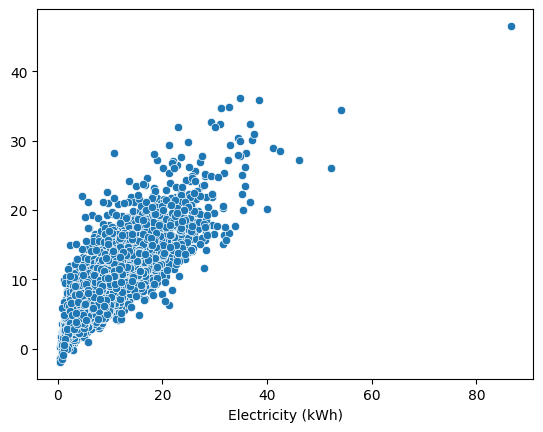

In [50]:
import seaborn as sns
sns.scatterplot(x=y_test,y=y_pred)

In [51]:
y_test

5688     8.711963
41411    5.865093
14216    8.253027
18490    4.725548
35462    8.657001
           ...   
29949    9.531690
43422    3.488589
35041    5.204274
14623    9.644924
15639    3.537507
Name: Electricity (kWh), Length: 9023, dtype: float64

In [52]:
mean_absolute_percentage_error(y_test, y_pred)*100

27.685415474890302

In [58]:
# Pickle the model
import pickle
filename = '../../xgb_model.pkl'
pickle.dump(pipe_xgb, open(filename, 'wb'))

In [55]:
# test model with dummy data
static_features = {
        'temp_mean': 8.846784796250905,
        'temp_min': 5.772831652443755,
        'temp_max': 12.269387121799843,
        'entry_floor': 0.6943588606893495,
        'income_band_num': 6.117300232738557,
        'electric_appliance': 7.8318962651002995,
        'gas_appliance': 3.623473345893827,
        'total_area': 859.6971073922199,
        'windowsopen': 5.805297572869334,
        'mean_h': 51.72884702264284,
        'min_h': 47.39651056424444,
        'max_h': 57.8116507886928,
        'average_age_numeric': 38.89990210203554,
        'total_participants': 2.436528870663859}

other_features = {
    'residents': 2.43830211681259,
    'room_count': 8.602748531530533,
    'workstatus': 0.14854298274779265,
    'hometype': 'house_or_bungalow'
}

#combine static and dynamic features into a single dict
features = {**static_features, **other_features}

pd.DataFrame(features, index=[0])

,temp_mean,temp_min,temp_max,entry_floor,income_band_num,electric_appliance,gas_appliance,total_area,windowsopen,mean_h,min_h,max_h,average_age_numeric,total_participants,residents,room_count,workstatus,hometype
0,8.846785,5.772832,12.269387,0.694359,6.1173,7.831896,3.623473,859.697107,5.805298,51.728847,47.396511,57.811651,38.899902,2.436529,2.438302,8.602749,0.148543,house_or_bungalow


In [59]:
prediction = pipe_xgb.predict(pd.DataFrame(features, index=[0]))

In [63]:
prediction[0].tolist()

6.6917595863342285

6.436405658721924

{'prediction': 7.832000255584717}